## Modeling

For the model, I will use Temporal Fusion Transformer from PyTorchForecasting library. This library yields several class and methods to facilitate the work with TimeSeries with excellents results.
Initially, I will use TimeSeriesDataset to create a PyTorch dataset (my TimeSeries) and then use DataLoaders to create batches to  fit the model.</br>
More information about this model can be found: 
[Temporal Fusion Transformer ](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html)

In [16]:
import pandas as pd
import pickle
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, MAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Load final preprocessed Dataset
data = pd.read_csv('./output/dataset.csv')

# Convert to Category applicable features
data.item_code = data.item_code.astype(str).astype("category")
data.group_ids = data.group_ids.astype(str).astype("category")
data.month = data.month.astype(str).astype("category")

data.head()

,item_code,quantity,avg_price,date,min_temp,max_temp,log_quantity,month,sma4,time_idx,group_ids
0,20209,168.0,6.990000,2017-12-01,36.0,84.0,5.123964,12,NaN,0,1
1,50215,453.0,9.898158,2017-12-01,36.0,84.0,6.115892,12,NaN,0,3
2,70165,808.0,9.823333,2017-12-01,36.0,84.0,6.694562,12,NaN,0,2
3,70208,664.0,10.666764,2017-12-01,36.0,84.0,6.498282,12,NaN,0,4
4,70270,56.0,3.250000,2017-12-01,36.0,84.0,4.025352,12,NaN,0,0


In [3]:
data[data['time_idx']==39]

,item_code,quantity,avg_price,date,min_temp,max_temp,log_quantity,month,sma4,time_idx,group_ids
234,20209,766.0,7.160161,2021-03-01,39.0,89.0,6.641182,3,510.00,39,1
235,50215,444.0,10.322308,2021-03-01,39.0,89.0,6.095825,3,377.00,39,3
236,70165,275.0,9.337826,2021-03-01,39.0,89.0,5.616771,3,459.25,39,2
237,70208,555.0,10.922500,2021-03-01,39.0,89.0,6.318968,3,458.75,39,4
238,70270,1296.0,3.555556,2021-03-01,39.0,89.0,7.167038,3,797.50,39,0
239,70271,438.0,11.222750,2021-03-01,39.0,89.0,6.082219,3,360.00,39,5


In [4]:
# Create Dataset and Dataloaders
min_encoder_length = 24
max_encoder_length = 36
min_prediction_length = 2
max_prediction_length = 4
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],    
    time_idx="time_idx",
    target="quantity",
    group_ids=["item_code"],
    min_encoder_length=min_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['item_code'],
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=['time_idx', 'avg_price'],
    time_varying_unknown_reals=['quantity','min_temp','log_quantity'],
    target_normalizer=GroupNormalizer(groups=['item_code'], transformation="softplus")
)

# validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [5]:
validation.decoded_index['time_idx_first_prediction'].max()

36

## Create Baseline Model as a simple Benchmark
Evaluating a Baseline model using validation dataset to predict last 3 months in each time series


In [6]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
print('MAE (Mean Absolute Error): {}'.format(MAE()(baseline_predictions, actuals)))

MAE (Mean Absolute Error): 161.0


## Finding Optimal Hyperparameters
Before training the model, I will use "optimize_hyperparameters" to get some clue where to start with hyperparameters identify an optimal learning rate.

In [10]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 2.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 1),
    dropout_range=(0.1, 0.5),
    trainer_kwargs=dict(limit_train_batches=64),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2021-05-08 09:09:53,300] A new study created in memory with name: no-name-9439b009-2bbd-4643-95dd-9dfacb2d5c75
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[I 2021-05-08 09:10:16,332] Trial 0 finished with value: 79.0201416015625 and parameters: {'gradient_clip_val': 0.11520720856815725, 'hidden_size': 9, 'dropout': 0.35442743278691635, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.002766961489927825}. Best is trial 0 with value: 79.0201416015625.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[I 2021-05-08 09:10:45,563] Trial 1 finished with value: 60.65003967285156 and parameters: {'gradient_clip_val': 0.031574233204133974, 'hidden_size': 39, 'dropout': 0.18474349215918906, 'hidden_continuous_size': 11, 'attention_head_size': 3, 'learning_rate': 0.007601533610572806}. Best is trial 1 with value: 60.65003967285156.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
[I 2021-

{'gradient_clip_val': 1.5784964502297822, 'hidden_size': 91, 'dropout': 0.19546775364620028, 'hidden_continuous_size': 32, 'attention_head_size': 3, 'learning_rate': 0.25616977609956665}


## Training Model

The model I will use is Temporal Fusion Transformer which has beaten algorithms like DeepAR by more than 30%, and also allow us modelling using covariates. Moreover, this model has shown very good result with short time series.

In [12]:
# Training the model (TemporalFusionTransformer)
# configure network and trainer

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(max_epochs=50,
                     min_epochs=10,
                     check_val_every_n_epoch=1,
                     gpus=0,
                     weights_summary="top",
                     gradient_clip_val=1.5784,
#                      limit_train_batches= 200,  # coment in for training, running valiation every 30 batches
                     # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
                     callbacks=[lr_logger, early_stop_callback],
                     logger=logger
                    )


tft_model = TemporalFusionTransformer.from_dataset(training,
                                                   learning_rate=0.3,
                                                   hidden_size=64,
                                                   attention_head_size=3,
                                                   dropout=0.3,
                                                   hidden_continuous_size=24,
                                                   loss=MAE(),
                                                   log_interval=1,
                                                   reduce_on_plateau_patience=4
                                                  )
print(f"Number of parameters in network: {tft_model.size()/1e3:.1f}k")
                                                  

# Fit the model
trainer.fit(tft_model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 248.1k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 96    
3  | prescalers                         | ModuleDict                      | 288   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 10.1 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 16.8

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [13]:
# Model Evaluation
# Select best model according to loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [17]:
# calcualte mean absolute error on validation dataset
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft_model.predict(val_dataloader)
# (actuals - predictions).abs().mean()
print(f'MAE = {mean_absolute_error(actuals, predictions)}')

MAE = 127.19847869873047


In [18]:
# raw predictions is a dictionary from which all kind of information reference to predictions
raw_predictions, x = best_tft_model.predict(val_dataloader, mode="raw", return_x=True)

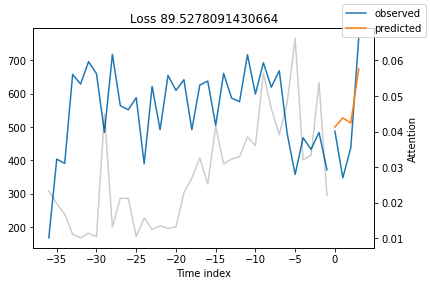

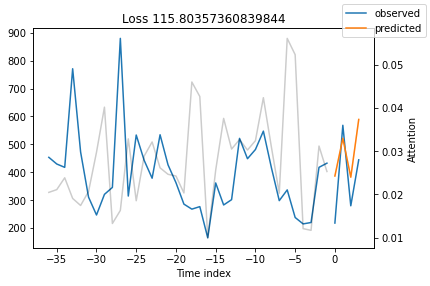

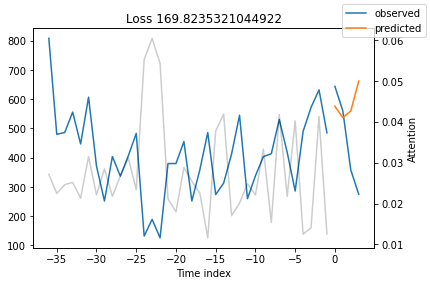

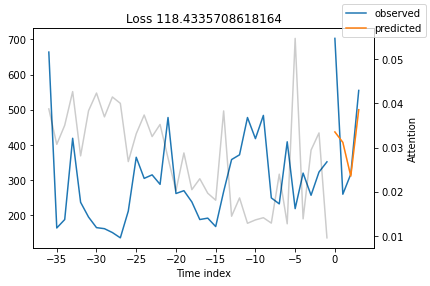

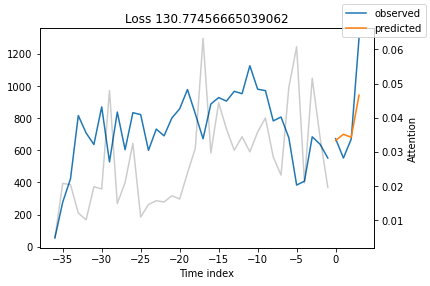

In [21]:
# Display 5 samples predictions using validation set
for idx in range(5):  # plot 5 examples
    best_tft_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

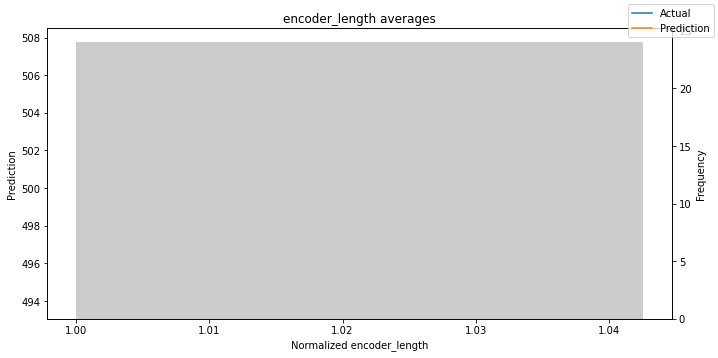

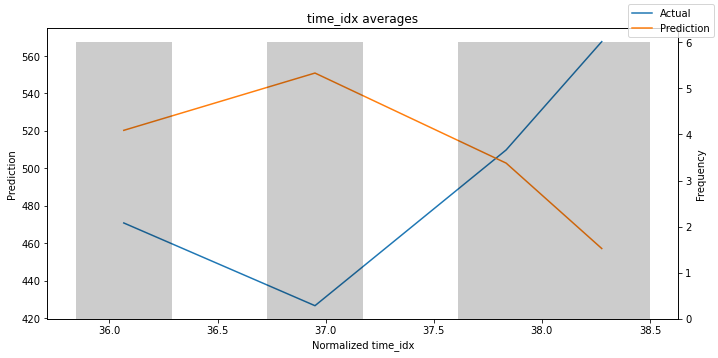

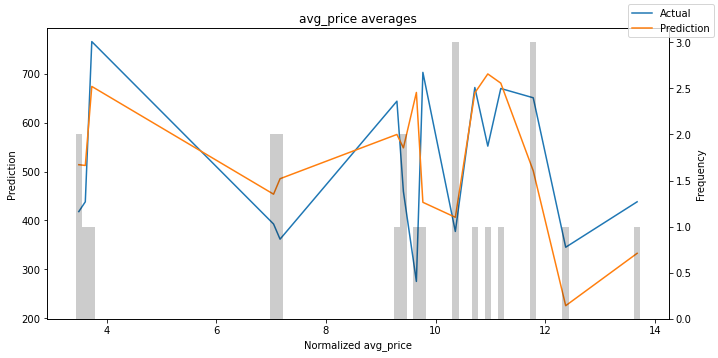

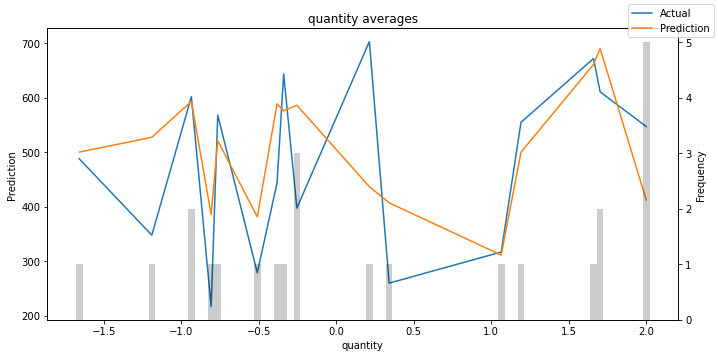

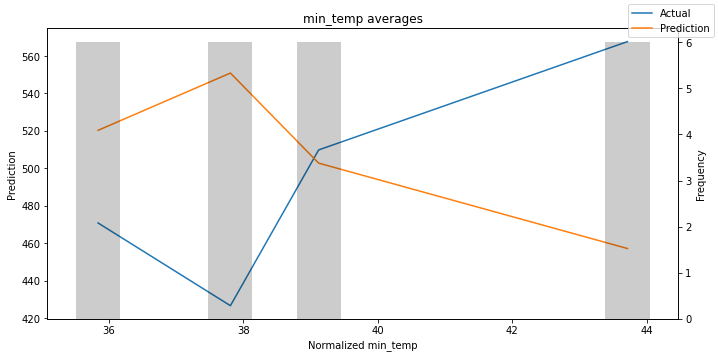

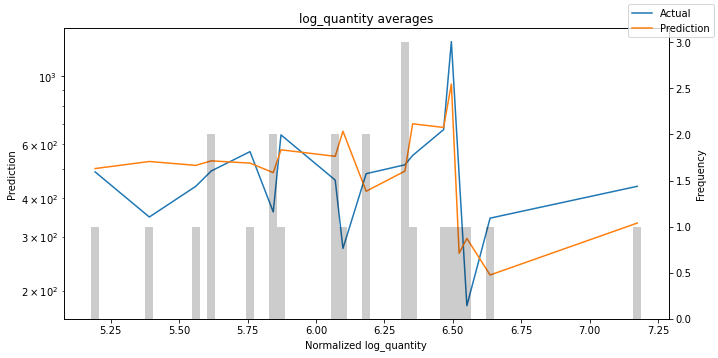

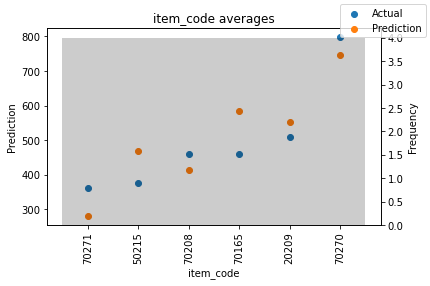

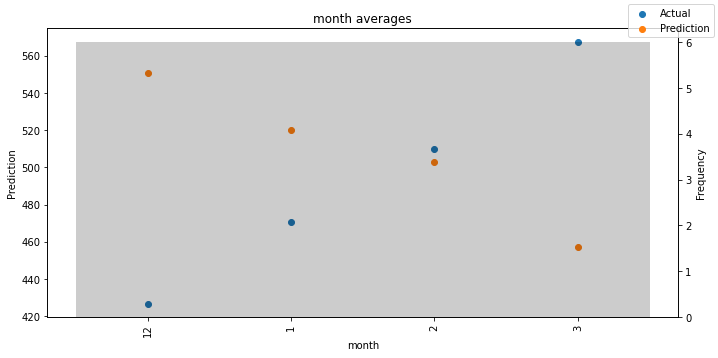

In [22]:
# Prediction x variable

predictions_vs_actuals = best_tft_model.calculate_prediction_actual_by_variable(x, predictions)
best_tft_model.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x180 with 1 Axes>,
 'encoder_variables': <Figure size 504x252 with 1 Axes>,
 'decoder_variables': <Figure size 504x198 with 1 Axes>}

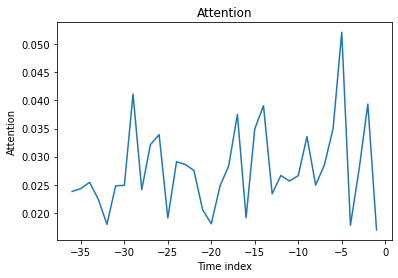

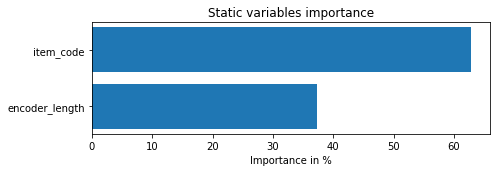

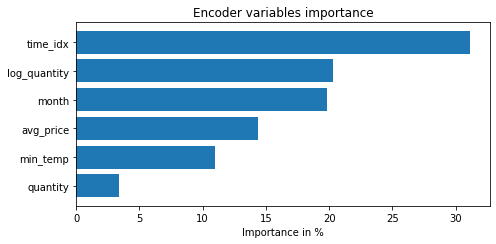

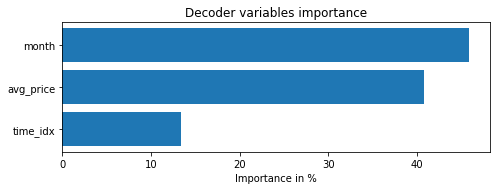

In [23]:
# Interpretation of the model

interpretation = best_tft_model.interpret_output(raw_predictions, reduction="sum")
best_tft_model.plot_interpretation(interpretation)

In [24]:
# Dictionary with interesting Products for the project
target_items = {'70270':'Le Contesse, Prosecchino Brut, 187ml',
                '20209':'Alverdi, Pinot Grigio',
                '70165':'Santome, Prosecco Extra Dry',
                '50215':'Carpineto, Dogajolo Rosso',
                '70208':'Italo Cescon, Pinot Grigio',
                '70271':'Le Contesse, Pinot Noir Rose Brut'
               }

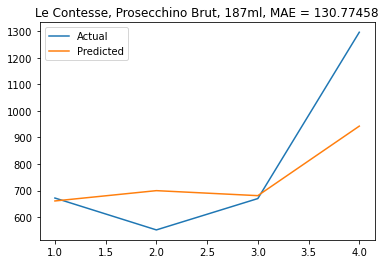

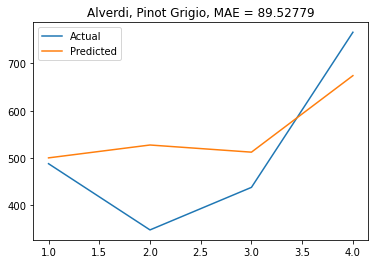

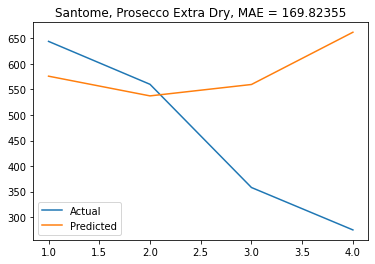

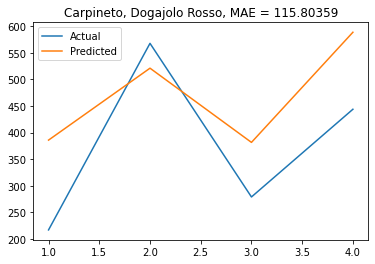

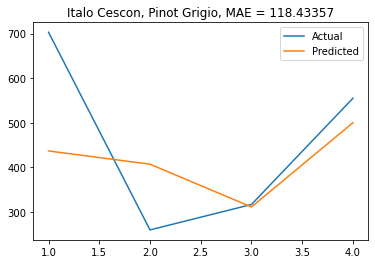

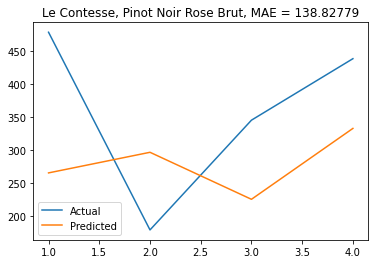

In [25]:
# Calculation MAE and MAPE for each Product
first_prediction = 36
for item_code, item_name in target_items.items():
    raw_prediction, x = best_tft_model.predict(
        validation.filter(lambda x: (x.item_code == item_code) & (x.time_idx_first_prediction == first_prediction)),
        mode="raw",
        return_x=True,
    )

    pred = raw_prediction['prediction'].reshape(-1)
    actual = x['decoder_target'].reshape(-1)
    error = mean_absolute_error(pred, actual)
    
    x = np.arange(1,41-first_prediction)
    plt.title(item_name + ', MAE = ' + str(error))
    plt.plot(x, actual)
    plt.plot(x, pred)
    plt.legend(labels=['Actual','Predicted'])
    plt.show()
#     print(f'Predictions: {pred}\nActual:{actual}')
#     print('MAE (Mean Absolute Error): {}'.format(mean_absolute_error(pred, actual)))

In [28]:
# best_tft_model